# Speech-based Emotion Recognition for Voice Comms.
## Main Notebook

Datasets used:

*   RAVDESS, CREMA-D
*   See AugmentData.ipynb for augmentation scripts    

In [411]:
import soundfile # read audio files
import numpy as np
import librosa # extract features
import glob
import os
import pickle # to save model after training
import time

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch
from torch import nn
import torch.optim as optim

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # for splitting training and testing data
from sklearn.utils import shuffle

import seaborn as sn
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# MLP PyTorch

In [412]:
#device setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [342]:
#defining utility class
#by defining this, you only have to write "for loop" to load minibatch data
class DataLoader(object):
    def __init__(self, x, y, batch_size, shuffle):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_idx = 0
        self.data_size = x.shape[0]
        if self.shuffle:
            self.reset()
    
    def reset(self):
        self.x, self.y = shuffle(self.x, self.y)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.start_idx >= self.data_size:
            if self.shuffle:
                self.reset()
            self.start_idx = 0
            raise StopIteration
    
        batch_x = self.x[self.start_idx:self.start_idx+self.batch_size]
        batch_y = self.y[self.start_idx:self.start_idx+self.batch_size]

        batch_x = torch.tensor(batch_x, dtype=torch.float, device=device)
        batch_y = torch.tensor(batch_y, dtype=torch.float, device=device)

        self.start_idx += self.batch_size

        return (batch_x,batch_y)

In [352]:
#defining MLP model
#generally out_dim is more than 1, but this model only allows 1.
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim_1, hidden_dim_2, out_dim=2):
        super(MLP, self).__init__()
        
        self.in_dim = in_dim
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2
        self.out_dim = out_dim
        
        ### 1st hidden layer
        self.linear_1 = nn.Linear(self.in_dim, self.hidden_dim_1)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### 2nd hidden layer
        self.linear_2 = torch.nn.Linear(self.hidden_dim_1, self.hidden_dim_2)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()
        
        ## Out layer
        self.linear_out = nn.Linear(self.hidden_dim_2, self.out_dim)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        
    
    def forward(self, x):
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        out = self.linear_out(out)
        #x = x.squeeze(1)
        return out

In [5]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32") # all depth 32bit float
        sample_rate = sound_file.samplerate # should always be 16kHz
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [6]:
# all emotions RAVDESS
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# all emotions CREMA-D
cemotion = {
    "NEU": "neutral",
    "HAP": "happy",
    "SAD": "sad",
    "ANG": "angry",
    "FEA": "fearful",
    "DIS": "disgust",
}

# allow only these emotions from dataset(s)
AVAILABLE_EMOTIONS = {
    "neutral",
    "calm", # only included in RAVDESS
    "happy",
    "sad",
    "angry", 
    "fearful",
    "disgust",
    "surprised" # in TESS specifies pleasant surprise
}

# map emotion to 2D space
circumplex_model = {
    "neutral":[(0.0, 0.0), "grey"],
    "calm":[(0.5,-0.7),"cyan"], # only included in RAVDESS
    "happy":[(0.8, 0.1),"purple"],
    "sad":[(-0.8, -0.3),"blue"],
    "angry":[(-0.2,0.7),"red"],
    "fearful":[(-0.4,0.7),"magenta"], #circumplex afraid
    "disgust":[(-0.41,0.6),"green"], #circumplex annoyed
    "surprised":[(0.3,0.7),"orange"], #circumplex astonished, in TESS specifies pleasant surprise
}

# map emotion to 3d space
pad_model = {
    
}

In [376]:
# load data and extract features
X, y = [], []
Xa, ya = [], []

# RAVDESS clean
for file in glob.glob("data/RAVDESS-nosil/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only circumplex model emotions
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    X.append(features)
    y.append(circumplex_coord)

# augmented RAVDESS
# white noise
for file in glob.glob("data/augment-wn/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    Xa.append(features)
    ya.append(circumplex_coord)

# overdrive
for file in glob.glob("data/augment-overdrive/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    Xa.append(features)
    ya.append(circumplex_coord)
    
# CREMA-D clean
for file in glob.glob("data/CREMA-D/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = cemotion[basename.split("_")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    X.append(features)
    y.append(circumplex_coord)

# scale features [1, -1]
X /= np.max(np.abs(X),axis=0)

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=420, stratify=y)

# scale features [1, -1]
Xa /= np.max(np.abs(Xa),axis=0)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(np.array(Xa),np.array(ya), test_size=0.1, random_state=420, stratify=ya)



# # label encoding for y
# label_encoder = preprocessing.LabelEncoder()
# label_encoder.fit(y)
# print("Class mapping: ")
# for i, item in enumerate(label_encoder.classes_):
#     print(item, "-->", i)

# encoded_labels = label_encoder.transform(y)
# print("Labels =", labels)
# print("Encoded labels =", list(encoded_labels))

# # split the data to training and testing and return it
# return train_test_split(np.array(X), np.array(y), test_size=test_size, random_state=420, stratify=y)

In [377]:
# # load dataset(s), 80% training 20% testing
# X_train, X_test, y_train, y_test = load_data(test_size=0.2)

In [ ]:
# print some details
# number of samples in training data
print("[+] Number of training samples:", X_train_a.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
# vector of features extracted 
# using extract_features() function
print("[+] Number of features:", X_train_a.shape[1])

In [399]:
train_loader = DataLoader(X_train_a, y_train_a,
                         batch_size=3000,
                          shuffle=True)# create your dataloader

test_loader = DataLoader(X_test, y_test,
                        batch_size=3000,
                          shuffle=True)# create your dataloader

# Checking the dataset
for features, labels in train_loader:  
    print('features dimensions:', features.shape)
    print('label dimensions:', labels.shape)
    break

# Checking the dataset
for features, labels in test_loader:  
    print('features dimensions:', features.shape)
    print('label dimensions:', labels.shape)
    break

features dimensions: torch.Size([2592, 40])
label dimensions: torch.Size([2592, 2])
features dimensions: torch.Size([1777, 40])
label dimensions: torch.Size([1777, 2])


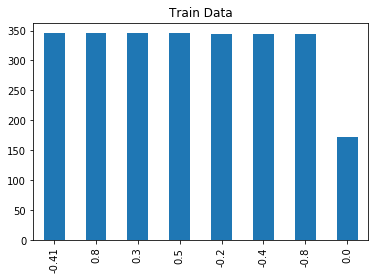

In [381]:
y_test_df = pd.DataFrame(data=y_train_a, columns=['X','Y',])
y_test_df['X'].value_counts().plot.bar(title='Train Data')

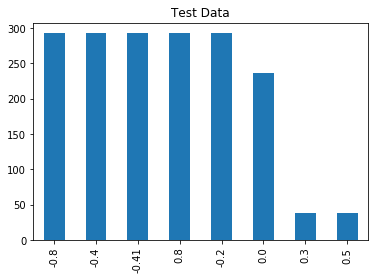

In [382]:
y_test_df = pd.DataFrame(data=y_test, columns=['X','Y',])
y_test_df['X'].value_counts().plot.bar(title='Test Data')

In [379]:
#instantiate model
mlp = MLP(X_train_a.shape[1], 256, 128, y_train_a.shape[1]).to(device)
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.1)

In [383]:
#this model learns to minimize MAE
def mae_loss(y_pred, y_true):
    mae = torch.abs(y_true - y_pred).mean()
    return mae

In [407]:
# training phase
epochs = 500
# to plot loss curve after training
valid_losses = []

for epoch in range(epochs):
    start_time = time.time()
    mlp.train()
    num_batch = train_loader.data_size // train_loader.batch_size + 1
    
    for batch_id, (batch_x, batch_y) in enumerate(train_loader):
        
        y_pred = mlp(batch_x)

        loss = mae_loss(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time
        elapsed_min = int(elapsed_time / 60)
        elapsed_sec = elapsed_time - 60 * elapsed_min

        print('\rEpoch:{} Batch:{}/{} Loss:{:.4f} Time:{}m{:.2f}s'.format(epoch + 1, batch_id, 
                                                                          num_batch, loss.item(),
                                                                          elapsed_min, elapsed_sec), end='')
    print()
    mlp.eval()
    valid_loss = 0
    best_loss = np.inf
    num_batch = test_loader.data_size // test_loader.batch_size + 1
    
    for batch_id, (batch_x, batch_y) in enumerate(test_loader):
    
        y_pred = mlp(batch_x)
        loss = mae_loss(y_pred, batch_y)
        valid_loss += loss.item()
    
    valid_loss /= num_batch
    valid_losses.append(valid_loss)
    
    #save model when validation loss is minimum
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(mlp.state_dict(), 'mlp.model')  
    
    print('Valid Loss:{:.4f}'.format(valid_loss))


Valid Loss:0.4244
Epoch:2 Batch:0/1 Loss:0.3057 Time:0m0.03s
Valid Loss:0.4609
Epoch:3 Batch:0/1 Loss:0.3074 Time:0m0.03s
Valid Loss:0.4228
Epoch:4 Batch:0/1 Loss:0.3066 Time:0m0.02s
Valid Loss:0.4650
Epoch:5 Batch:0/1 Loss:0.3092 Time:0m0.02s
Valid Loss:0.4199
Epoch:6 Batch:0/1 Loss:0.3086 Time:0m0.02s
Valid Loss:0.4726
Epoch:7 Batch:0/1 Loss:0.3135 Time:0m0.02s
Valid Loss:0.4163
Epoch:8 Batch:0/1 Loss:0.3122 Time:0m0.02s
Valid Loss:0.4774
Epoch:9 Batch:0/1 Loss:0.3168 Time:0m0.03s
Valid Loss:0.4152
Epoch:10 Batch:0/1 Loss:0.3128 Time:0m0.02s
Valid Loss:0.4772
Epoch:11 Batch:0/1 Loss:0.3170 Time:0m0.02s
Valid Loss:0.4157
Epoch:12 Batch:0/1 Loss:0.3119 Time:0m0.02s
Valid Loss:0.4757
Epoch:13 Batch:0/1 Loss:0.3160 Time:0m0.02s
Valid Loss:0.4162
Epoch:14 Batch:0/1 Loss:0.3113 Time:0m0.02s
Valid Loss:0.4745
Epoch:15 Batch:0/1 Loss:0.3150 Time:0m0.02s
Valid Loss:0.4172
Epoch:16 Batch:0/1 Loss:0.3103 Time:0m0.02s
Valid Loss:0.4717
Epoch:17 Batch:0/1 Loss:0.3130 Time:0m0.02s
Valid Loss:0.41

KeyboardInterrupt: 

minimum validation loss is 0.0000
torch.Size([1777, 2])
tensor([ 0.6135,  0.0342, -0.0071, -0.1111, -0.2608,  0.0575,  0.4453,  0.6039,
         0.0516, -0.1926,  0.1163,  0.0256, -0.0330, -0.1963, -0.0532,  0.0174,
        -0.2719, -0.1675,  0.6384,  0.1328,  0.0220, -0.1305,  0.0160,  0.1965,
        -0.1777,  1.0861, -0.2551, -0.2259, -0.0243,  0.2267, -0.6849, -0.1969],
       grad_fn=<SelectBackward>)
tensor([-0.1264,  0.6631,  0.4559,  0.3794,  0.4099,  0.1012, -0.1010, -0.9141,
         0.1783,  0.5580,  0.1816, -0.3094,  0.3006,  0.5716,  0.3114,  0.4962,
         0.4588,  0.7667, -0.2316,  0.2367,  0.2874,  0.4796,  0.1261,  0.1367,
         0.4652, -0.0347,  0.5219,  0.2942, -0.1006,  0.1410,  0.6751,  0.2163],
       grad_fn=<SelectBackward>)
torch.Size([1777, 2])
tensor([ 0.0000, -0.2000, -0.2000, -0.4000,  0.0000, -0.4100, -0.2000,  0.5000,
         0.0000, -0.2000, -0.4000, -0.8000, -0.4100,  0.8000,  0.0000, -0.4100,
        -0.2000, -0.2000, -0.4100, -0.4100,  0.8000, -

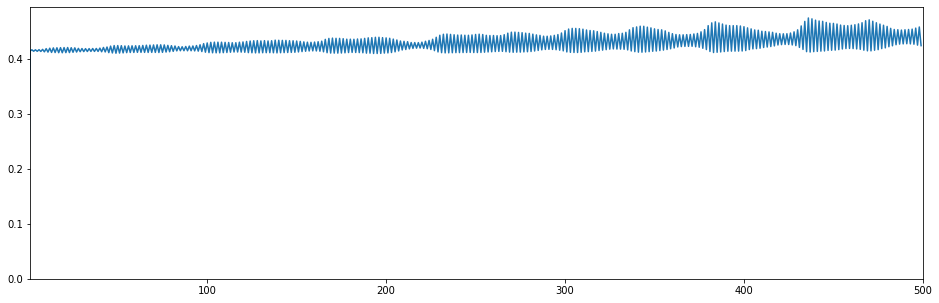

In [405]:
# plot validation loss curve, this may help to notice overfitting
plt.figure(figsize=(16,5))
plt.ylim(0,max(valid_losses)+0.02)
plt.xlim(1,500)
plt.plot(valid_losses)
print('minimum validation loss is {:.4f}'.format(min(valid_losses)))

# sanity
print(y_pred.shape)
print(y_pred[:32,0])
print(y_pred[:32,1])
print(batch_y.shape)
print(batch_y[:32,0])
print(batch_y[:32,1])

In [388]:
#load the best model
mlp.load_state_dict(torch.load('mlp.model'))

x_test = torch.tensor(X_test,dtype=torch.float,device=device)

#predict
y_pred = mlp(x_test)
y_pred = y_pred.data.cpu().numpy()

x_test.shape[0]

1777

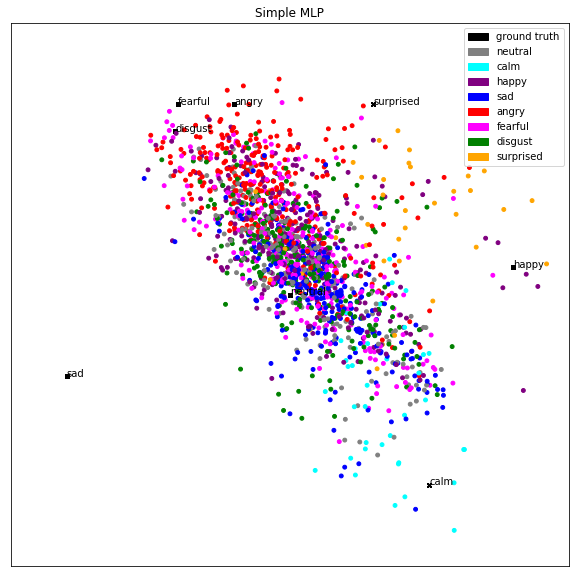

      True x  True y    Pred x    Pred y
0      -0.41     0.6 -0.014834  0.168766
1      -0.40     0.7 -0.025728  0.187437
2      -0.41     0.6  0.330648 -0.032462
3      -0.80    -0.3  0.041452  0.038515
4      -0.80    -0.3 -0.063685  0.053698
...      ...     ...       ...       ...
1772   -0.20     0.7 -0.035495  0.233166
1773   -0.80    -0.3 -0.177456  0.290428
1774   -0.41     0.6 -0.101461  0.213261
1775   -0.41     0.6  0.463096 -0.256910
1776   -0.20     0.7 -0.017248  0.495836

[1777 rows x 4 columns]

Mean Absolute Error: 0.41643488684483354
Mean Squared Error: 0.25678915208043585
Root Mean Squared Error: 0.5067436749288893


In [391]:
# plotting
plt.figure(figsize=(10,10))
plt.title('Simple MLP')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_test)):
    for key, value in circumplex_model.items():
        if tuple(y_test[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_test[:,0], y_test[:,1], color='black', s=15, marker='x')
plt.scatter(y_pred[:,0], y_pred[:,1], c=colors, s=15, marker='o')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xticks([])
plt.yticks([])

for key, value in circumplex_model.items():
    plt.annotate(key, value[0])

# legend
black_patch = mpatches.Patch(color='black', label='ground truth')
grey_patch = mpatches.Patch(color='grey', label='neutral')
cyan_patch = mpatches.Patch(color='cyan', label='calm')
purple_patch = mpatches.Patch(color='purple', label='happy')
blue_patch = mpatches.Patch(color='blue', label='sad')
red_patch = mpatches.Patch(color='red', label='angry')
magenta_patch = mpatches.Patch(color='magenta', label='fearful')
green_patch = mpatches.Patch(color='green', label='disgust')
orange_patch = mpatches.Patch(color='orange', label='surprised')

plt.legend(handles=[black_patch,
                    grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    magenta_patch,
                    green_patch,
                    orange_patch])

plt.show()

df_rfr = pd.DataFrame({'True x':y_test[:,0], 
                        'True y':y_test[:,1],
                        'Pred x':y_pred[:,0], 
                        'Pred y':y_pred[:,1]})
print(df_rfr)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# MLPRegressor and RandomForestRegressor Sklearn

In [1078]:
mlp_params = {
    'batch_size': 'auto',
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 100, 
    'verbose':1,
    'n_iter_no_change':10,
    'early_stopping':True,
    'random_state':420,
}

In [1079]:
mlp = MLPRegressor(**mlp_params)
mlp.out_activation_ = 'logistic'
mlp.fit(X_train_a, y_train_a)

Iteration 1, loss = 0.14668076
Validation score: -0.003615
Iteration 2, loss = 0.12527926
Validation score: 0.089012
Iteration 3, loss = 0.11602449
Validation score: 0.102063
Iteration 4, loss = 0.11102973
Validation score: 0.124175
Iteration 5, loss = 0.10715313
Validation score: 0.147513
Iteration 6, loss = 0.10391503
Validation score: 0.158160
Iteration 7, loss = 0.10125263


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Validation score: 0.166625
Iteration 8, loss = 0.09957487
Validation score: 0.191150
Iteration 9, loss = 0.09706519
Validation score: 0.185267
Iteration 10, loss = 0.09516096
Validation score: 0.203484
Iteration 11, loss = 0.09407358
Validation score: 0.197318
Iteration 12, loss = 0.09244008
Validation score: 0.193500
Iteration 13, loss = 0.09075383
Validation score: 0.211358
Iteration 14, loss = 0.08949642
Validation score: 0.232857
Iteration 15, loss = 0.08836755
Validation score: 0.212877
Iteration 16, loss = 0.08728377
Validation score: 0.228624
Iteration 17, loss = 0.08598950
Validation score: 0.235288
Iteration 18, loss = 0.08502698
Validation score: 0.237742
Iteration 19, loss = 0.08383693
Validation score: 0.225476
Iteration 20, loss = 0.08292646
Validation score: 0.247727


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 21, loss = 0.08175851
Validation score: 0.225471
Iteration 22, loss = 0.08143301
Validation score: 0.254147
Iteration 23, loss = 0.08023223
Validation score: 0.248851
Iteration 24, loss = 0.07895173
Validation score: 0.265479
Iteration 25, loss = 0.07839335
Validation score: 0.267087


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 26, loss = 0.07730976
Validation score: 0.259731
Iteration 27, loss = 0.07672817
Validation score: 0.266935
Iteration 28, loss = 0.07577588
Validation score: 0.274087
Iteration 29, loss = 0.07513588
Validation score: 0.282314
Iteration 30, loss = 0.07409112
Validation score: 0.264824
Iteration 31, loss = 0.07380725


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Validation score: 0.262744
Iteration 32, loss = 0.07298672
Validation score: 0.288190
Iteration 33, loss = 0.07199430
Validation score: 0.294215
Iteration 34, loss = 0.07184224
Validation score: 0.293445
Iteration 35, loss = 0.07135112
Validation score: 0.302991


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 36, loss = 0.07064779
Validation score: 0.281247
Iteration 37, loss = 0.06954653
Validation score: 0.286971
Iteration 38, loss = 0.06847440
Validation score: 0.282231
Iteration 39, loss = 0.06788804
Validation score: 0.304015
Iteration 40, loss = 0.06698671
Validation score: 0.305866
Iteration 41, loss = 0.06660080
Validation score: 0.299684
Iteration 42, loss = 0.06599237


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Validation score: 0.290738
Iteration 43, loss = 0.06575204
Validation score: 0.312425
Iteration 44, loss = 0.06473614
Validation score: 0.307761


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 45, loss = 0.06430979
Validation score: 0.307449
Iteration 46, loss = 0.06384054
Validation score: 0.319460
Iteration 47, loss = 0.06282291
Validation score: 0.316307
Iteration 48, loss = 0.06235000
Validation score: 0.317085
Iteration 49, loss = 0.06206241
Validation score: 0.332412
Iteration 50, loss = 0.06114929
Validation score: 0.333973


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 51, loss = 0.06099537
Validation score: 0.338707
Iteration 52, loss = 0.06012585
Validation score: 0.322920
Iteration 53, loss = 0.05989936
Validation score: 0.340596
Iteration 54, loss = 0.05953338
Validation score: 0.341467
Iteration 55, loss = 0.05907412
Validation score: 0.347438
Iteration 56, loss = 0.05858564
Validation score: 0.342724


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 57, loss = 0.05804212
Validation score: 0.339037
Iteration 58, loss = 0.05822598
Validation score: 0.339404
Iteration 59, loss = 0.05718432
Validation score: 0.329521
Iteration 60, loss = 0.05704001
Validation score: 0.345836
Iteration 61, loss = 0.05615865
Validation score: 0.354421
Iteration 62, loss = 0.05567425
Validation score: 0.353899


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 63, loss = 0.05504894
Validation score: 0.352597
Iteration 64, loss = 0.05465402
Validation score: 0.357121
Iteration 65, loss = 0.05434628
Validation score: 0.366190
Iteration 66, loss = 0.05417749
Validation score: 0.363722
Iteration 67, loss = 0.05407190
Validation score: 0.363768
Iteration 68, loss = 0.05351078
Validation score: 0.360406


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 69, loss = 0.05295535
Validation score: 0.369074
Iteration 70, loss = 0.05287263
Validation score: 0.366533
Iteration 71, loss = 0.05221188
Validation score: 0.364080
Iteration 72, loss = 0.05178759
Validation score: 0.369841
Iteration 73, loss = 0.05145563
Validation score: 0.375097
Iteration 74, loss = 0.05159714
Validation score: 0.370378
Iteration 75, loss = 0.05048739


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Validation score: 0.377354
Iteration 76, loss = 0.05050213
Validation score: 0.371045
Iteration 77, loss = 0.05018775
Validation score: 0.369733
Iteration 78, loss = 0.04982281
Validation score: 0.376873
Iteration 79, loss = 0.04915458
Validation score: 0.375031
Iteration 80, loss = 0.04884871


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Validation score: 0.376523
Iteration 81, loss = 0.04854354
Validation score: 0.381147
Iteration 82, loss = 0.04881931
Validation score: 0.379483
Iteration 83, loss = 0.04796348
Validation score: 0.364340
Iteration 84, loss = 0.04757353
Validation score: 0.373447


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 85, loss = 0.04743445
Validation score: 0.387408
Iteration 86, loss = 0.04717252
Validation score: 0.382846
Iteration 87, loss = 0.04716509
Validation score: 0.382742
Iteration 88, loss = 0.04681868
Validation score: 0.387852
Iteration 89, loss = 0.04620933
Validation score: 0.382632
Iteration 90, loss = 0.04661650
Validation score: 0.384839


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 91, loss = 0.04609455
Validation score: 0.376031
Iteration 92, loss = 0.04512402
Validation score: 0.388244
Iteration 93, loss = 0.04549132
Validation score: 0.376609
Iteration 94, loss = 0.04472654
Validation score: 0.384946
Iteration 95, loss = 0.04486968
Validation score: 0.369172


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 96, loss = 0.04441623
Validation score: 0.384106
Iteration 97, loss = 0.04377640
Validation score: 0.377190
Iteration 98, loss = 0.04350886
Validation score: 0.392256
Iteration 99, loss = 0.04347758
Validation score: 0.393683
Iteration 100, loss = 0.04315334
Validation score: 0.390913


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(300,), learning_rate='adaptive',
             learning_rate_init=0.001, max_iter=100, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=420, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=1, warm_start=False)

In [1080]:
y_predict_mlp = mlp.predict(X_test)

In [1045]:
rfr_params = {
    'verbose': 10,
    'n_estimators': 100,
    'max_depth': None,
    'random_state': 420,
    'min_samples_split': 4,
    'min_samples_leaf': 3,
}

In [1046]:
# init regr
rfr = RandomForestRegressor(**rfr_params)

In [1047]:
# train the model
print("[*] Training the model...")
rfr.fit(X_train_a, y_train_a)

[*] Training the model...
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s


building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.2s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=420,
                      verbose=10, warm_start=False)

In [1048]:
y_predict_rfr = rfr.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


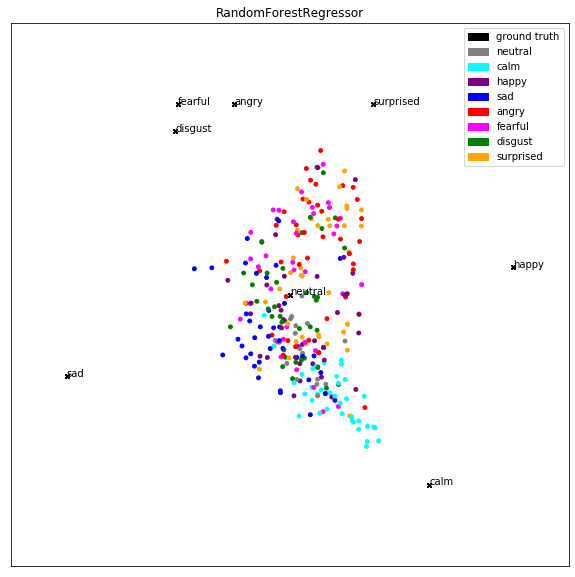

     True x  True y    Pred x    Pred y
0      -0.2     0.7 -0.019893  0.304497
1       0.8     0.1  0.046089 -0.183323
2       0.8     0.1 -0.082013  0.035022
3       0.0     0.0  0.130789 -0.363614
4      -0.2     0.7  0.182037  0.203950
..      ...     ...       ...       ...
283    -0.4     0.7  0.081311  0.320712
284     0.5    -0.7  0.247303 -0.496166
285     0.3     0.7  0.196822  0.454618
286     0.3     0.7  0.207223 -0.109583
287    -0.2     0.7 -0.226757  0.122398

[288 rows x 4 columns]

Mean Absolute Error: 0.43508150231182785
Mean Squared Error: 0.2532238411017731
Root Mean Squared Error: 0.5032135144268018


In [1065]:
# plotting
plt.figure(figsize=(10,10))
plt.title('RandomForestRegressor')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_test)):
    for key, value in circumplex_model.items():
        if tuple(y_test[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_test[:,0], y_test[:,1], color='black', s=15, marker='x')
plt.scatter(y_predict_rfr[:,0],y_predict_rfr[:,1], c=colors, s=15, marker='o')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xticks([])
plt.yticks([])

for key, value in circumplex_model.items():
    plt.annotate(key, value[0])

# legend
black_patch = mpatches.Patch(color='black', label='ground truth')
grey_patch = mpatches.Patch(color='grey', label='neutral')
cyan_patch = mpatches.Patch(color='cyan', label='calm')
purple_patch = mpatches.Patch(color='purple', label='happy')
blue_patch = mpatches.Patch(color='blue', label='sad')
red_patch = mpatches.Patch(color='red', label='angry')
magenta_patch = mpatches.Patch(color='magenta', label='fearful')
green_patch = mpatches.Patch(color='green', label='disgust')
orange_patch = mpatches.Patch(color='orange', label='surprised')

plt.legend(handles=[black_patch,
                    grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    magenta_patch,
                    green_patch,
                    orange_patch])

plt.show()

df_rfr = pd.DataFrame({'True x':y_test[:,0], 
                        'True y':y_test[:,1],
                        'Pred x':y_predict_rfr[:,0], 
                        'Pred y':y_predict_rfr[:,1]})
print(df_rfr)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict_rfr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict_rfr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict_rfr)))

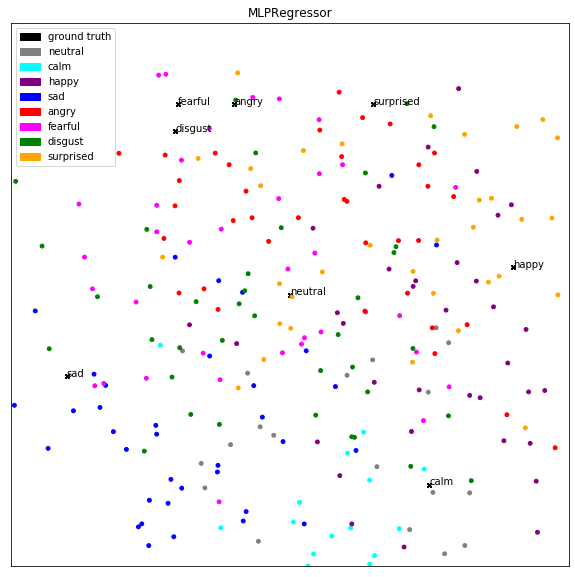

     True x  True y    Pred x    Pred y
0      -0.2     0.7  0.205277  0.342706
1       0.8     0.1  0.883591 -0.686884
2       0.8     0.1  0.730493 -0.045441
3       0.0     0.0  0.644996 -0.729898
4      -0.2     0.7  0.587704  0.360225
..      ...     ...       ...       ...
283    -0.4     0.7 -1.344002  0.967754
284     0.5    -0.7  0.684240 -1.021886
285     0.3     0.7  0.505113  0.657757
286     0.3     0.7  0.961172 -0.001197
287    -0.2     0.7 -0.446297  0.512997

[288 rows x 4 columns]

Mean Absolute Error: 0.4522583608228947
Mean Squared Error: 0.30127970315440855
Root Mean Squared Error: 0.5488895181677352


In [1081]:
# plotting
plt.figure(figsize=(10,10))
plt.title('MLPRegressor')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_test)):
    for key, value in circumplex_model.items():
        if tuple(y_test[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_test[:,0], y_test[:,1], color='black', s=15, marker='x')
plt.scatter(y_predict_mlp[:,0],y_predict_mlp[:,1], c=colors, s=15, marker='o')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xticks([])
plt.yticks([])

for key, value in circumplex_model.items():
    plt.annotate(key, value[0])

# legend
black_patch = mpatches.Patch(color='black', label='ground truth')
grey_patch = mpatches.Patch(color='grey', label='neutral')
cyan_patch = mpatches.Patch(color='cyan', label='calm')
purple_patch = mpatches.Patch(color='purple', label='happy')
blue_patch = mpatches.Patch(color='blue', label='sad')
red_patch = mpatches.Patch(color='red', label='angry')
magenta_patch = mpatches.Patch(color='magenta', label='fearful')
green_patch = mpatches.Patch(color='green', label='disgust')
orange_patch = mpatches.Patch(color='orange', label='surprised')

plt.legend(handles=[black_patch,
                    grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    magenta_patch,
                    green_patch,
                    orange_patch])

plt.show()

df_rfr = pd.DataFrame({'True x':y_test[:,0], 
                        'True y':y_test[:,1],
                        'Pred x':y_predict_mlp[:,0], 
                        'Pred y':y_predict_mlp[:,1]})
print(df_rfr)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict_mlp))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict_mlp))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict_mlp)))

In [379]:
# save the model
# make result directory if doesn't exist yet
if not os.path.isdir("result"):
    os.mkdir("result")

pickle.dump(rfr, open("result/rfr.model", "wb"))